A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable.

We will use the following packages to do data loading and processing
- `scikit-image`: For image io and transforms
- `pandas`: For easier csv parsing

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion()         # interactive mode

The dataset we are going to deal with is that of facial pose.

In [2]:
landmarks_frame = pd.read_csv('./faces/face_landmarks.csv')
landmarks_frame.head(2)

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312


Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.

In [3]:
n = 50

img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image Name : {}'.format(img_name))
print('Landmark Shape : {}'.format(landmarks.shape))
print('First 4 landmarks : {}'.format(landmarks[:4]))

Image Name : 3689162471_5f9ffb5aa0.jpg
Landmark Shape : (68, 2)
First 4 landmarks : [[237.  83.]
 [235.  94.]
 [233. 106.]
 [233. 118.]]


Helper Function to show the image and associated landmarks

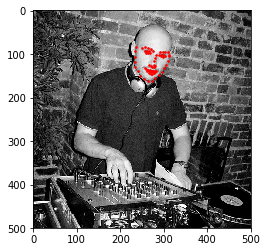

In [4]:
def show_landmarks(images, landmarks):
    plt.imshow(images)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, marker = '.', c = 'r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

**Dataset class**
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

Let’s create a dataset class for our face landmarks dataset. We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict `{'image': image, 'landmarks': landmarks}`. Our datset will take an optional argument `transform` so that any required processing can be applied on the sample.

In [5]:
class FaceLandmarkDataSet(Dataset):
    """"Face Landmark Dataset"""
    def __init__(self, csv_file, root_dir, transform=None):
        """
            csv_file : csv filename with all the annotations
            root_dir : directory with all the images
            transform : additional argument that do transform all the images
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
        sample = {'images' : image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

Initiate this class and see some plots

0 (324, 215, 3) (68, 2)


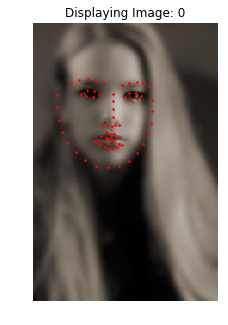

1 (500, 333, 3) (68, 2)


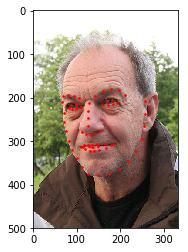

2 (250, 258, 3) (68, 2)


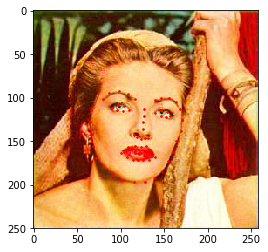

3 (434, 290, 3) (68, 2)


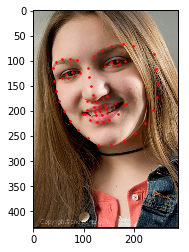

4 (828, 630, 3) (68, 2)


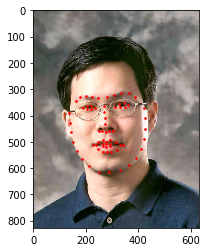

5 (402, 500, 3) (68, 2)


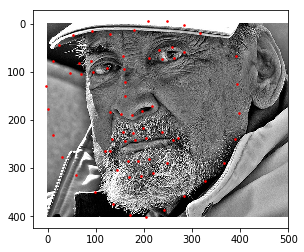

6 (332, 500, 3) (68, 2)


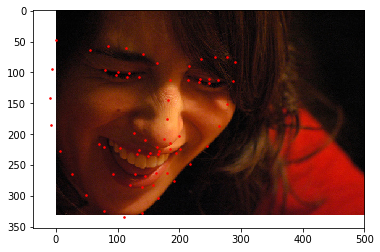

7 (333, 500, 3) (68, 2)


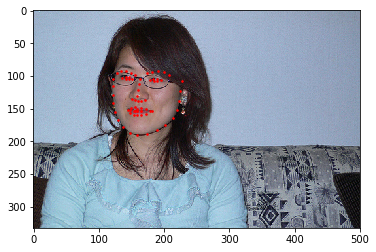

8 (334, 500, 3) (68, 2)


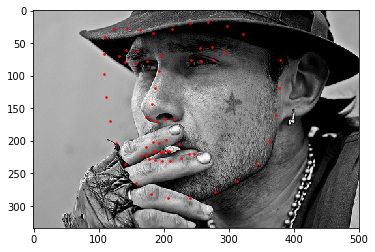

9 (376, 500, 3) (68, 2)


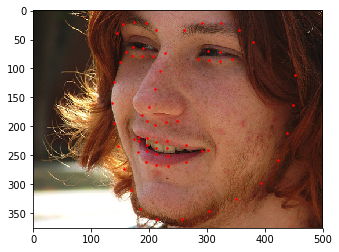

10 (333, 500, 3) (68, 2)


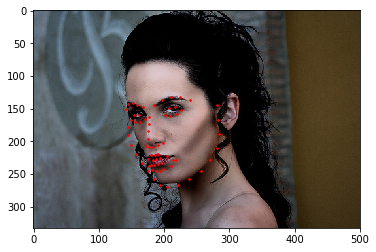

In [6]:
face_dataset = FaceLandmarkDataSet(csv_file = 'faces/face_landmarks.csv', root_dir = './faces/')
fig = plt.figure(figsize=[6,6])

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['images'].shape, sample['landmarks'].shape)   
    
    ax = fig.add_subplot(121)
    plt.tight_layout()
    ax.set_title('Displaying Image: {}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 10:
        break

**Transforms**
One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:

- `Rescale`: to scale the image
- `RandomCrop`: to crop from image randomly. This is data augmentation.
- `ToTensor`: to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement `__call__` method and if required, `__init__` method. We can then use a transform like this:

<i>
tsfm = Transform(params)<br/>
transformed_sample = tsfm(sample)
</i>

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['images'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'images': img, 'landmarks': landmarks}

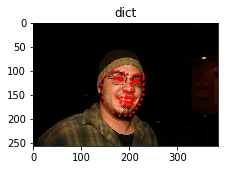

In [8]:
# Apply ReScale transforms on sample.

scale = Rescale(256)

fig = plt.figure()
sample = face_dataset[45]
trans = scale(sample)
ax = plt.subplot(121)
plt.tight_layout()
ax.set_title(type(trans).__name__)
show_landmarks(**trans)

plt.show()

In [9]:
class RandomCrop(object):
    """Crop Randomly the image in the sample.
    Args:
        output size (tuple, int): Desired output size. 
                If int then a square crop will happen. 
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple, int))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) ==2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['images'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top: top+new_h, 
                     left: left+new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'images' : image, 'landmarks' : landmarks}                

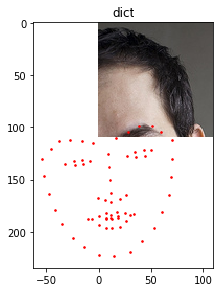

In [10]:
# Apply RandomCrop transforms on sample.

Rcrop = RandomCrop(110)

fig = plt.figure()
sample = face_dataset[40]
trans = Rcrop(sample)
ax = plt.subplot(121)
plt.tight_layout()
ax.set_title(type(trans).__name__)
show_landmarks(**trans)

plt.show()

**Compose**

Lets see the combined result of Rescale and Randome Crop and also differentiate between `Rescaled version`, `RandomCrop version` and `Composed version`.

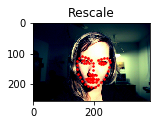

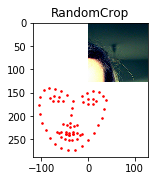

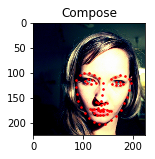

In [11]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[32]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['images'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'images': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

**Combining what we have got**
**Iterating through the dataset**
Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

- An image is read from the file on the fly
- Transforms are applied on the read image
- Since one of the transforms is random, data is augmentated on sampling

In [13]:
transformed_dataset = FaceLandmarkDataSet(csv_file='faces/face_landmarks.csv',
                                          root_dir='faces/',
                                          transform=transforms.Compose([Rescale(256),
                                                                        RandomCrop(200),
                                                                        ToTensor()]))

In [14]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['images'].size(), sample['landmarks'].size())
    
    if i==3:
        break

0 torch.Size([3, 200, 200]) torch.Size([68, 2])
1 torch.Size([3, 200, 200]) torch.Size([68, 2])
2 torch.Size([3, 200, 200]) torch.Size([68, 2])
3 torch.Size([3, 200, 200]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 torch.Size([4, 3, 200, 200]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 200, 200]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 200, 200]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 200, 200]) torch.Size([4, 68, 2])


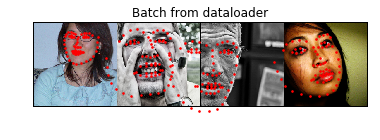

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7ff721f5cf28>>
Traceback (most recent call last):
  File "/home/mayank/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/mayank/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mayank/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mayank/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mayank/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/mayank/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, i

In [15]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['images'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['images'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break